<a href="https://colab.research.google.com/github/sharminmousumi/Angular-Blogg/blob/master/paddleocr_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install Python packages
!pip install "paddleocr>=2.7.0" "paddlepaddle>=2.5.0" pdf2image rapidfuzz jiwer matplotlib


In [ ]:
#upload the PDF and set pdf_path
from google.colab import files
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]

Saving aa602a2b-0cf0-5d8f-8050-4e73aa4e3d6c_2.pdf to aa602a2b-0cf0-5d8f-8050-4e73aa4e3d6c_2 (1).pdf


In [ ]:
#Now convert_from_path will work
from pdf2image import convert_from_path

pages = convert_from_path(pdf_path, dpi=150)
print("Pages loaded:", len(pages))


Pages loaded: 68


In [ ]:
from paddleocr import PaddleOCR
import numpy as np

# CPU only
ocr = PaddleOCR(lang='en', use_gpu=False)

all_pages_text = []

for i, page in enumerate(pages):
    print(f"OCR on page {i+1}/{len(pages)}...")
    img = np.array(page)

    result = ocr.ocr(img)

    page_lines = []

    # result is usually a list for this image
    for entry in result:
        # Case 1: dict-style modern output
        if isinstance(entry, dict) and "data" in entry:
            for det in entry["data"]:
                text = det.get("text", "")
                if text:
                    page_lines.append(text)

        # Case 2: older list/tuple style
        elif isinstance(entry, (list, tuple)):
            for item in entry:
                if isinstance(item, (list, tuple)) and len(item) >= 2:
                    text_info = item[1]
                    if isinstance(text_info, (list, tuple)) and len(text_info) >= 1:
                        text = text_info[0]
                    else:
                        text = str(text_info)
                    if text:
                        page_lines.append(text)

    all_pages_text.append("\n".join(page_lines))

paddle_text = "\n\n".join(all_pages_text)

with open("paddle.txt", "w", encoding="utf-8") as f:
    f.write(paddle_text)

print("Saved PaddleOCR output to paddle.txt, length:", len(paddle_text))


In [ ]:
# 3. Import libraries
from transformers import AutoProcessor, AutoTokenizer, VisionEncoderDecoderModel
from pdf2image import convert_from_path
import torch

In [ ]:
#Install poppler
!apt-get update
!apt-get install -y poppler-utils


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,836 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,008 kB]
Get:13 http://archive.ubuntu.com/ubuntu 

In [ ]:
!ls

'aa602a2b-0cf0-5d8f-8050-4e73aa4e3d6c_2 (1).pdf'   sample_data
 aa602a2b-0cf0-5d8f-8050-4e73aa4e3d6c_2.pdf


In [ ]:
#Create gold.txt from PDF
!pip install pdfminer.six

from pdfminer.high_level import extract_text

gold_text = extract_text(pdf_path)

with open("gold.txt", "w", encoding="utf-8") as f:
    f.write(gold_text)

print("Gold text length:", len(gold_text))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 46.6 MB/s eta 0:00:00
Gold text length: 214713


In [ ]:
#Compute WER & CER for PaddleOCR
from jiwer import wer
from rapidfuzz.distance import Levenshtein

def cer(ref: str, hyp: str) -> float:
    """
    Character Error Rate = edit_distance / len(ref)
    """
    dist = Levenshtein.distance(ref, hyp)
    return dist / max(1, len(ref))

paddle_wer = wer(gold_text, pdf_path)
paddle_cer = cer(gold_text, pdf_path)

print("PaddleOCR WER:", paddle_wer)
print("PaddleOCR CER:", paddle_cer)


PaddleOCR WER: 1.0
PaddleOCR CER: 0.9997904179066941


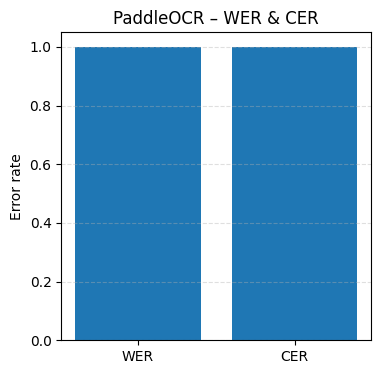

In [ ]:
#Visualize WER & CER for PaddleOCR

import matplotlib.pyplot as plt

metrics = ["WER", "CER"]
values = [paddle_wer, paddle_cer]

plt.figure(figsize=(4,4))
plt.bar(metrics, values)
plt.ylim(0, 1.05)
plt.ylabel("Error rate")
plt.title("PaddleOCR – WER & CER")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


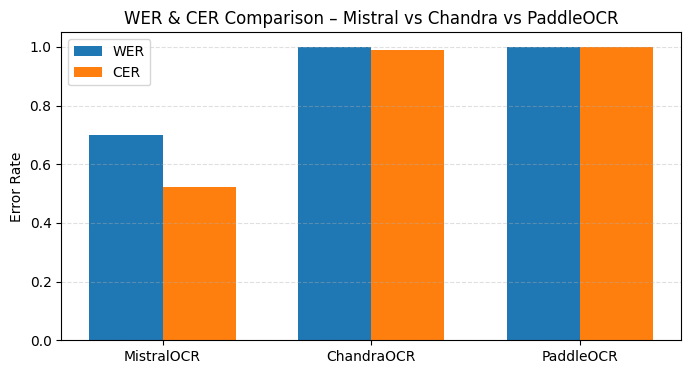

In [ ]:
#Visualize WER & CER
import matplotlib.pyplot as plt
import numpy as np

models = ["MistralOCR", "ChandraOCR", "PaddleOCR"]
wer_values = [0.7006, 0.9982, 1.0]
cer_values = [0.5242, 0.9883, 0.99979]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, wer_values, width, label="WER")
plt.bar(x + width/2, cer_values, width, label="CER")
plt.xticks(x, models)
plt.ylim(0, 1.05)
plt.ylabel("Error Rate")
plt.title("WER & CER Comparison – Mistral vs Chandra vs PaddleOCR")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()
